# Bank Marketing Classification Models

**Dataset**: UCI Bank Marketing Dataset
**Goal**: Predict whether a customer subscribes to a term deposit.

## 1. Import Required Libraries

In [8]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    confusion_matrix
)

import joblib
import os


## 2. Load Dataset

In [24]:

df = pd.read_csv("bank_marketing.csv")
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


## 3. Dataset Overview

In [25]:

df.info()
df['y'].value_counts()


<class 'pandas.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        4521 non-null   int64
 1   job        4521 non-null   str  
 2   marital    4521 non-null   str  
 3   education  4521 non-null   str  
 4   default    4521 non-null   str  
 5   balance    4521 non-null   int64
 6   housing    4521 non-null   str  
 7   loan       4521 non-null   str  
 8   contact    4521 non-null   str  
 9   day        4521 non-null   int64
 10  month      4521 non-null   str  
 11  duration   4521 non-null   int64
 12  campaign   4521 non-null   int64
 13  pdays      4521 non-null   int64
 14  previous   4521 non-null   int64
 15  poutcome   4521 non-null   str  
 16  y          4521 non-null   str  
dtypes: int64(7), str(10)
memory usage: 600.6 KB


y
no     4000
yes     521
Name: count, dtype: int64

## 4. Data Preprocessing
Categorical features are label encoded.

In [26]:

categorical_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


/var/folders/0v/49x5nx693cg5w9fsy0ylfj800000gp/T/ipykernel_21939/2003011340.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = df.select_dtypes(include=['object']).columns


## 5. Feature and Target Split

In [27]:

X = df.drop('y', axis=1)
y = df['y']


## 6. Train-Test Split

In [28]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## 7. Feature Scaling

In [29]:

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [30]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(3616, 16)
(905, 16)


## 8. Initialize Models

In [31]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )
}


## 9. Train Models and Evaluate Metrics

In [32]:

results = []

for name, model in models.items():
    if name in ["Logistic Regression", "KNN"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "MCC": matthews_corrcoef(y_test, y_pred)
    })


/Users/n0k00km/tf_env/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [15:50:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 10. Model Comparison Table

In [33]:

results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,AUC,Precision,Recall,F1,MCC
0,Logistic Regression,0.882873,0.854485,0.475000,0.182692,0.263889,0.242795
1,Decision Tree,0.856354,0.667843,0.385965,0.423077,0.403670,0.322646
2,KNN,0.890608,0.743428,0.571429,0.192308,0.287770,0.287106
3,Naive Bayes,0.839779,0.821101,0.336000,0.403846,0.366812,0.277510
4,Random Forest,0.888398,0.900413,0.524590,0.307692,0.387879,0.345340
5,XGBoost,0.890608,0.913197,0.532468,0.394231,0.453039,0.399259


## 11. Save Models for Streamlit Deployment

In [34]:

os.makedirs("model", exist_ok=True)

for name, model in models.items():
    filename = name.lower().replace(" ", "_") + ".pkl"
    joblib.dump(model, f"model/{filename}")

joblib.dump(scaler, "model/scaler.pkl")


['model/scaler.pkl']

## 12. Confusion Matrices (All Models)

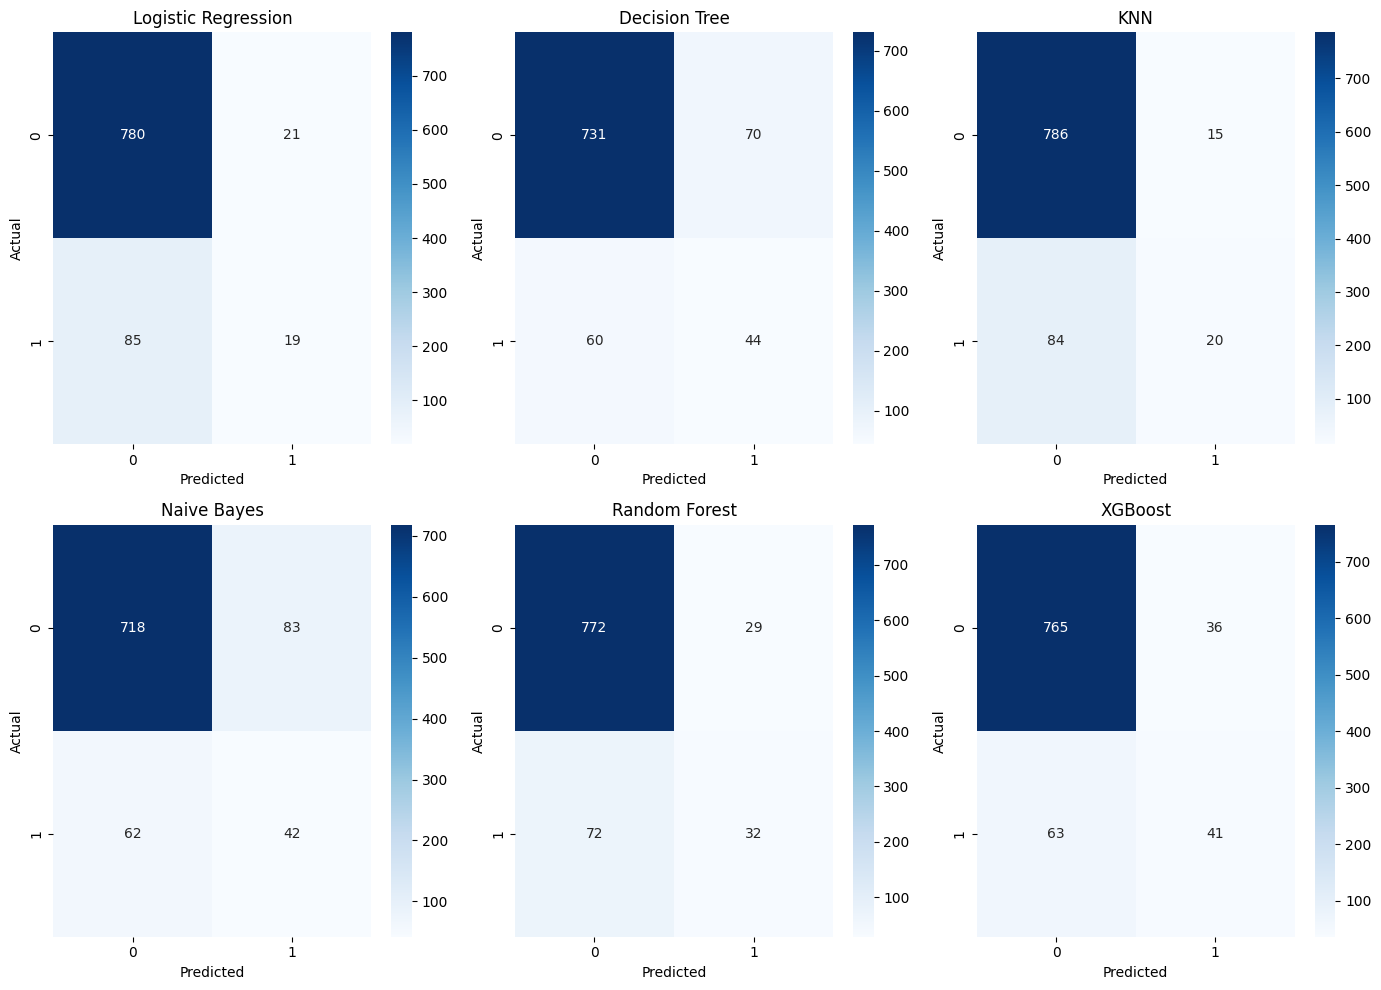

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    if name in ["Logistic Regression", "KNN"]:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")
    axes[idx].set_title(name)

plt.tight_layout()
plt.show()
